In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import structcol as sc
import structcol.refractive_index as ri
from structcol import montecarlo as mc
import pymie as pm
from pymie import size_parameter, index_ratio 
import seaborn as sns

In [2]:
# Montecarlo parameters
ntrajectories = 150000                    # number of trajectories # 2000 is good too
nevents = 300                           # number of scattering events in each trajectory

# Properties of system
wavelengths = sc.Quantity(np.arange(400, 800, 10), 'nm')
particle_radius = sc.Quantity('0.140 um')
volume_fraction = sc.Quantity(0.55, '') # rcp .64
n_imag = np.linspace(1e-3, 1e-6, wavelengths.size)
n_particle = ri.n('polystyrene', wavelengths)    # refractive indices can be specified as pint quantities or
n_matrix = ri.n('vacuum', wavelengths)      # called from the refractive_index module. n_matrix is the 
n_medium = ri.n('vacuum', wavelengths)      # space within sample. n_medium is outside the sample.3
z_low = sc.Quantity('0.0 um')
thickness = sc.Quantity('80 um')

# Properties of detector
det_theta = sc.Quantity('16 degrees')
det_dist = sc.Quantity('13 cm')
det_len = sc.Quantity('2.4 cm')

### Run Monte Carlo model and calculate reflectance and polarization for trajectories

In [3]:
pol_refl_x_sum = np.zeros(wavelengths.size)
pol_refl_y_sum = np.zeros(wavelengths.size)
pol_refl_z_sum = np.zeros(wavelengths.size)
pol_refl_loc_x_sum = np.zeros(wavelengths.size)
pol_refl_loc_y_sum = np.zeros(wavelengths.size)
reflectance = np.zeros(wavelengths.size)

for i in range(wavelengths.size):
    print(wavelengths[i])
    n_sample = ri.n_eff(n_particle[i], n_matrix[i], volume_fraction) 

    #%%timeit
    p, mu_scat, mu_abs = mc.calc_scat(particle_radius, n_particle[i], n_sample, 
                                      volume_fraction, wavelengths[i], polarization=True)
    # Initialize the trajectories
    r0, k0, W0, p0 = mc.initialize(nevents, ntrajectories, n_medium[i], 
                                   n_sample, pol_inc = np.array([1,0,0]))
    r0 = sc.Quantity(r0, 'um')
    k0 = sc.Quantity(k0, '')
    W0 = sc.Quantity(W0, '')
    p0 = sc.Quantity(p0, '')

    # Generate a matrix of all the randomly sampled angles first 
    sintheta, costheta, sinphi, cosphi, theta, phi = mc.sample_angles_pol(nevents, ntrajectories, p)
    #sintheta, costheta, sinphi, cosphi, theta, phi = mc.sample_angles(nevents, ntrajectories, p)

    # Generate a matrix of all the polarizations of randomly sampled angles
    singamma, cosgamma, pol_x_loc, pol_y_loc = mc.polarize(theta, phi, n_particle[i], n_sample, particle_radius, 
                                                           wavelengths[i], volume_fraction)

    # Create step size distribution
    step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)

    # Create trajectories object
    trajectories = mc.Trajectory(r0, k0, W0, p0)

    # Run photons
    trajectories.absorb(mu_abs, step)                         
    trajectories.scatter_polarization(sintheta, costheta, sinphi, cosphi,
                                      singamma, cosgamma)
    trajectories.move(step)


    refl_indices, trans_indices, _, _, _, _, _, _, _, reflectance[i] = mc.calc_refl_trans(trajectories, z_low, 
                                                                          thickness, n_medium[i], n_sample,
                                                                          return_extra = True, detector = True,
                                                                          det_theta = det_theta, det_len = det_len,
                                                                          det_dist = det_dist)

    pol_refl_x = mc.select_events(trajectories.polarization[0,:,:], refl_indices)
    pol_refl_y = mc.select_events(trajectories.polarization[1,:,:], refl_indices)
    pol_refl_z = mc.select_events(trajectories.polarization[2,:,:], refl_indices)
    
    pol_refl_loc_x = mc.select_events(pol_x_loc,refl_indices)
    pol_refl_loc_y = mc.select_events(pol_y_loc,refl_indices)
    pol_refl_loc_x_sum[i] = np.sum(np.abs(mc.select_events(pol_x_loc,refl_indices)))
    pol_refl_loc_y_sum[i] = np.sum(np.abs(mc.select_events(pol_y_loc,refl_indices)))
    
    #pol_refl_x = trajectories.polarization[0,:,:]
    #pol_refl_y = trajectories.polarization[1,:,:]
    #pol_refl_z = trajectories.polarization[2,:,:]
    
    pol_refl_x_sum[i] = np.sum(np.abs(pol_refl_x))
    pol_refl_y_sum[i] = np.sum(np.abs(pol_refl_y))
    pol_refl_z_sum[i] = np.sum(np.abs(pol_refl_z))

440 nanometer


/home/stephenson/Repositories/structural-color/structcol/montecarlo.py:1968: ComplexWarning: Casting complex values to real discards the imaginary part
  asmat[i,j,0,0] = S21[0]
/home/stephenson/Repositories/structural-color/structcol/montecarlo.py:1969: ComplexWarning: Casting complex values to real discards the imaginary part
  asmat[i,j,1,1] = S21[1]
/home/stephenson/Repositories/structural-color/structcol/montecarlo.py:922: RuntimeWarning: invalid value encountered in true_divide
  t_m = -b + np.sqrt(b**2-4*a*c)/(2*a)


450 nanometer
460 nanometer
470 nanometer
480 nanometer
490 nanometer
500 nanometer
510 nanometer
520 nanometer
530 nanometer
540 nanometer
550 nanometer
560 nanometer
570 nanometer
580 nanometer
590 nanometer
600 nanometer
610 nanometer
620 nanometer
630 nanometer
640 nanometer
650 nanometer
660 nanometer
670 nanometer
680 nanometer
690 nanometer
700 nanometer
710 nanometer
720 nanometer
730 nanometer
740 nanometer
750 nanometer
760 nanometer
770 nanometer
780 nanometer
790 nanometer


### Plot polarization intensity measurements

/home/stephenson/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


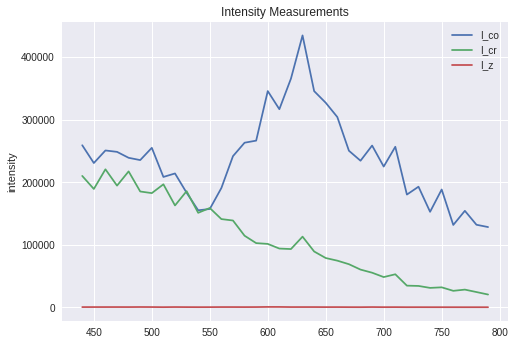

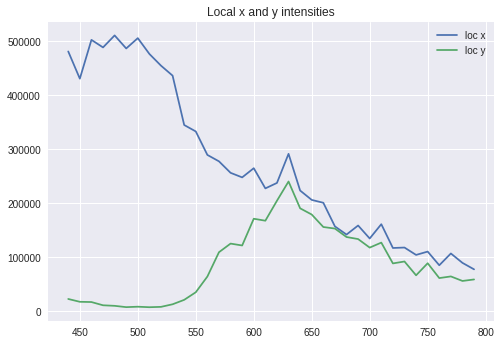

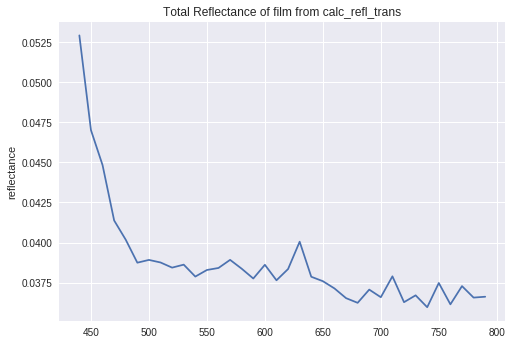

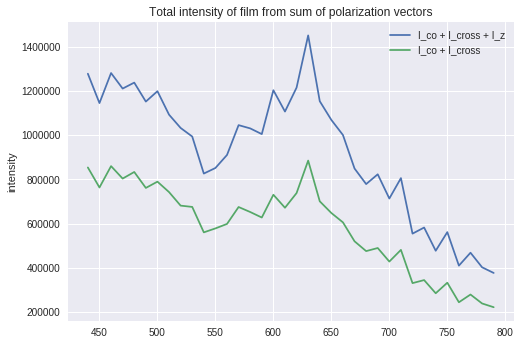

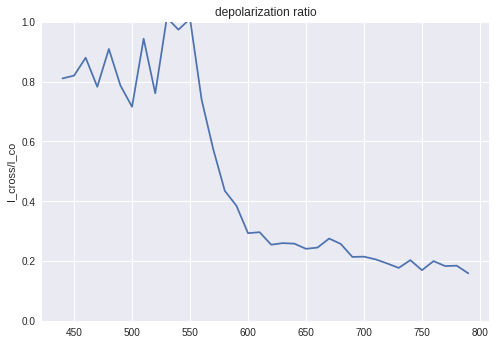

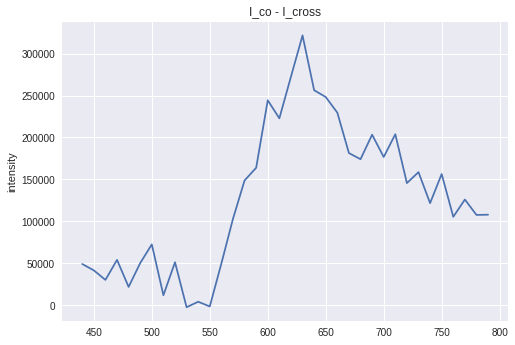

In [28]:
I_z = (-pol_refl_z_sum*np.cos(16*np.pi/180) + pol_refl_x_sum*np.sin(16*np.pi/180))**2
I_cr = pol_refl_y_sum**2
I_co = (pol_refl_z_sum*np.sin(16*np.pi/180) + pol_refl_x_sum*np.cos(16*np.pi/180))**2

plt.figure()
plt.plot(wavelengths, I_co , label = 'I_co')
plt.plot(wavelengths, I_cr, label = 'I_cr')
plt.plot(wavelengths, I_z, label = 'I_z')
#plt.ylim([0,5000])
plt.ylabel('intensity')
plt.title('Intensity Measurements')
plt.legend()

plt.figure()
plt.title('Local x and y intensities')
plt.plot(wavelengths, pol_refl_loc_x_sum**2, label = 'loc x')
plt.plot(wavelengths, pol_refl_loc_y_sum**2, label = 'loc y')
#plt.plot(wavelengths, pol_refl_loc_y_sum**2/pol_refl_loc_x_sum**2, label = 'ratio')
plt.legend()

plt.figure()
plt.title('Total Reflectance of film from calc_refl_trans')
plt.plot(wavelengths, reflectance)
plt.ylabel('reflectance')
plt.legend()

plt.figure()
#plt.plot(wavelengths, pol_refl_x_sum**2, label = 'pol x')
#plt.plot(wavelengths, pol_refl_y_sum**2, label = 'pol y')
#plt.plot(wavelengths, pol_refl_z_sum**2, label = 'pol z')
plt.plot(wavelengths, (pol_refl_y_sum + pol_refl_x_sum + pol_refl_z_sum)**2, label = 'I_co + I_cross + I_z')
plt.plot(wavelengths, (pol_refl_x_sum + pol_refl_y_sum)**2, label = 'I_co + I_cross')
plt.title('Total intensity of film from sum of polarization vectors')
plt.ylabel('intensity')
plt.legend()

plt.figure()
plt.plot(wavelengths, I_cr/I_co)
plt.title('depolarization ratio')
plt.ylabel('I_cross/I_co')
plt.ylim([0,1])
plt.legend()

plt.figure()
plt.ylabel('intensity')
plt.title('I_co - I_cross')
plt.plot(wavelengths, I_co - I_cr)
plt.legend()

### Plot average polarizations over time

(0, 10)

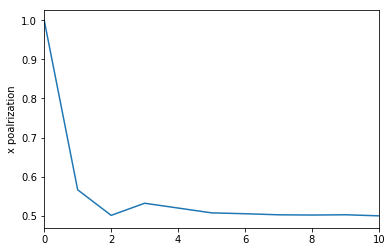

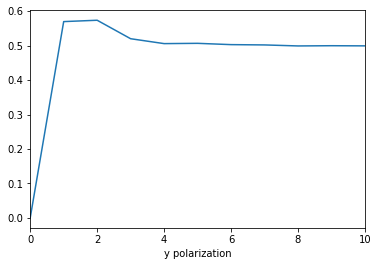

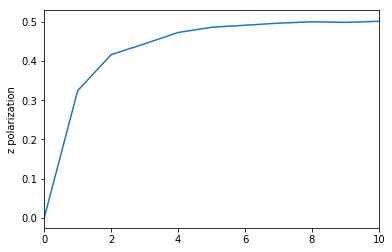

In [5]:
# x, nevent, ntraj
plt.figure()
pol_x_mean = np.mean(np.abs(trajectories.polarization[0,:,:]),axis=1)
plt.plot(pol_x_mean)
plt.ylabel('x poalrization')
plt.xlabel('event')
plt.xlim([0,10])

plt.figure()
pol_y_mean = np.mean(np.abs(trajectories.polarization[1,:,:]),axis=1)
plt.plot(pol_y_mean)
plt.ylabel('y polarization')
plt.xlabel('event')
plt.xlim([0,10])

plt.figure()
pol_z_mean = np.mean(np.abs(trajectories.polarization[2,:,:]),axis=1)
plt.plot(pol_z_mean)
plt.ylabel('z polarization')
plt.xlabel('event')
plt.xlim([0,10])

### Calculate single scattering model

In [7]:
refl = np.zeros(wavelengths.size)
refl_par = np.zeros(wavelengths.size)
refl_perp = np.zeros(wavelengths.size)
for i in range(wavelengths.size):
    refl[i], refl_par[i], refl_perp[i], _, _ = sc.model.reflection(n_particle[i], n_matrix[i],
                                                     n_medium[i], wavelengths[i],
                                                     particle_radius, volume_fraction, 
                                                     thickness = thickness,
                                                     theta_min = sc.Quantity('170 deg'), #158
                                                     theta_max = sc.Quantity('180 deg'), #170
                                                     phi_min = sc.Quantity('0 deg'),
                                                     phi_max = sc.Quantity('360 deg'))
    

refl_2 = np.zeros(wavelengths.size)
refl_par_2 = np.zeros(wavelengths.size)
refl_perp_2 = np.zeros(wavelengths.size)    
for i in range(wavelengths.size):
    refl_2[i], refl_par_2[i], refl_perp_2[i], _, _ = sc.model.reflection(n_particle[i], n_matrix[i],
                                                     n_medium[i], wavelengths[i],
                                                     particle_radius, volume_fraction, 
                                                     thickness = thickness,
                                                     theta_min = sc.Quantity('90 deg'), #158
                                                     theta_max = sc.Quantity('100 deg'), #170
                                                     phi_min = sc.Quantity('0 deg'),
                                                     phi_max = sc.Quantity('360 deg'))


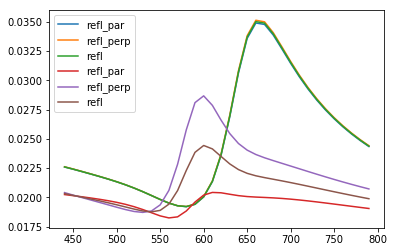

In [8]:
plt.figure()
plt.plot(wavelengths, refl_par, label = 'refl_par')
plt.plot(wavelengths, refl_perp, label = 'refl_perp')
plt.plot(wavelengths, refl, label = 'refl')

plt.plot(wavelengths, refl_par_2, label = 'refl_par')
plt.plot(wavelengths, refl_perp_2, label = 'refl_perp')
plt.plot(wavelengths, refl_2, label = 'refl')
plt.legend()

### Plot phase function in theta and phi

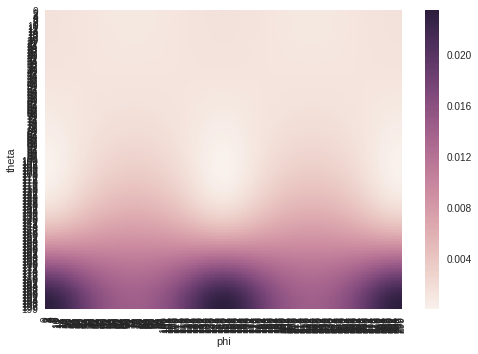

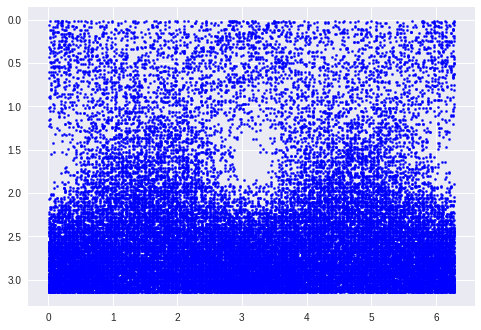

In [10]:
ax = sns.heatmap(p)
plt.xlabel('phi')
plt.ylabel('theta')

plt.figure()
plt.scatter(phi[0,:], theta[0,:], color = 'b', s = 5)
plt.gca().invert_yaxis()
#plt.scatter(phi[1,:], np.flip(theta[1,:]), color = 'b', s =5)